<a href="https://colab.research.google.com/github/CamiloVga/Codes/blob/main/ChatGPT_harrypotter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instalación de librerías necesarias para ejecutar en GPU T4 de Colab
!pip install PyPDF2
!pip install nltk
!pip install tqdm
!pip install matplotlib

# Descargar recursos NLTK necesarios
import nltk
nltk.download('punkt')

# Verificar configuración de GPU
import torch
print(f"GPU disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Nombre de GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memoria GPU total: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

    # GPT Harry Potter - Implementación Personalizada
# Este script implementa un modelo GPT simple desde cero utilizando libros de Harry Potter

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import re
import random
from google.colab import files
import PyPDF2
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

# Configurar semilla para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Verificar si tenemos GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilizando dispositivo: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 13.4 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


GPU disponible: True
Nombre de GPU: Tesla T4
Memoria GPU total: 15.83 GB
Utilizando dispositivo: cuda


In [2]:


#################################################
# FASE 1: CARGA Y PREPARACIÓN DE DATOS
#################################################

# Crear directorio para libros si no existe
!mkdir -p libros

print("Por favor, sube tus archivos PDF a la carpeta 'libros'")
print("Puedes cargarlos manualmente en el panel lateral izquierdo de Colab")
print("Una vez subidos, ejecuta la siguiente celda...")

Por favor, sube tus archivos PDF a la carpeta 'libros'
Puedes cargarlos manualmente en el panel lateral izquierdo de Colab
Una vez subidos, ejecuta la siguiente celda...


In [3]:


# Función para extraer texto de PDFs
def extraer_texto_de_pdf(ruta_archivo):
    texto = ""
    with open(ruta_archivo, 'rb') as archivo:
        lector_pdf = PyPDF2.PdfReader(archivo)
        for pagina in lector_pdf.pages:
            texto += pagina.extract_text()
    return texto

# Función para extraer texto de todos los PDFs en una carpeta
def procesar_todos_pdfs(directorio):
    textos = []
    nombres = []

    # Listar todos los archivos PDF en el directorio
    archivos_pdf = [f for f in os.listdir(directorio) if f.endswith('.pdf')]

    if len(archivos_pdf) == 0:
        print("No se encontraron archivos PDF en la carpeta 'libros'")
        return [], []

    print(f"Encontrados {len(archivos_pdf)} archivos PDF")

    # Procesar cada archivo
    for archivo in archivos_pdf:
        ruta_completa = os.path.join(directorio, archivo)
        print(f"Procesando: {archivo}...")

        try:
            texto = extraer_texto_de_pdf(ruta_completa)
            textos.append(texto)
            nombres.append(archivo)
            print(f"  → Extraídos {len(texto)} caracteres")
        except Exception as e:
            print(f"Error al procesar {archivo}: {e}")

    return textos, nombres

# Ejecutar la extracción de textos
textos_libros, nombres_libros = procesar_todos_pdfs('libros')

# Verificar que se hayan cargado correctamente
if textos_libros:
    print("\nTextos cargados correctamente:")
    for nombre, texto in zip(nombres_libros, textos_libros):
        print(f"- {nombre}: {len(texto)} caracteres, comienza con: '{texto[:50]}...'")

    # Combinar todos los textos en uno solo para el entrenamiento
    texto_completo = "\n\n".join(textos_libros)
    print(f"\nTexto completo: {len(texto_completo)} caracteres")
else:
    print("No se pudieron cargar los textos. Verifica que hayas subido los PDFs correctamente.")

Encontrados 2 archivos PDF
Procesando: Sorcerer's Stone.pdf...
  → Extraídos 434817 caracteres
Procesando: HP-chamber-of-secret.pdf...
  → Extraídos 775343 caracteres

Textos cargados correctamente:
- Sorcerer's Stone.pdf: 434817 caracteres, comienza con: '1Harry Potter and the Sorcerer's Stone
CHAPTER ONE...'
- HP-chamber-of-secret.pdf: 775343 caracteres, comienza con: ' 
H A R R Y  P O T T E R
A N D  T H E  C H A M B E...'

Texto completo: 1210162 caracteres


In [ ]:


#################################################
# FASE 2: TOKENIZACIÓN Y PREPARACIÓN DE VOCABULARIO
#################################################

# Función para limpiar y normalizar el texto
def limpiar_texto(texto):
    # Convertir a minúsculas
    texto = texto.lower()
    # Eliminar caracteres especiales pero mantener puntuación básica
    texto = re.sub(r'[^\w\s\.,!?:;]', '', texto)
    # Normalizar espacios en blanco
    texto = re.sub(r'\s+', ' ', texto)
    return texto

# Limpiamos el texto completo
texto_limpio = limpiar_texto(texto_completo)
print(f"Texto limpio: {len(texto_limpio)} caracteres")
print(f"Muestra: '{texto_limpio[:100]}...'")

# Tokenización a nivel de caracteres (más simple para empezar)
# También podríamos hacer tokenización a nivel de palabras o subpalabras

class CharTokenizer:
    def __init__(self):
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def fit(self, texto):
        # Identificar caracteres únicos
        chars = sorted(list(set(texto)))

        # Crear mapeos
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        self.vocab_size = len(chars)

        return self

    def encode(self, texto):
        # Convertir texto a índices
        return [self.char_to_idx[ch] for ch in texto if ch in self.char_to_idx]

    def decode(self, indices):
        # Convertir índices a texto
        return ''.join([self.idx_to_char[idx] for idx in indices if idx in self.idx_to_char])

# Crear y entrenar el tokenizador
tokenizer = CharTokenizer().fit(texto_limpio)

print(f"Tamaño del vocabulario: {tokenizer.vocab_size} caracteres únicos")
print("Primeros 20 tokens del vocabulario:")
for i, (char, idx) in enumerate(list(tokenizer.char_to_idx.items())[:20]):
    print(f"  {char} → {idx}")

# Tokenizar todo el texto
indices = tokenizer.encode(texto_limpio)
print(f"Texto tokenizado: {len(indices)} tokens")
print(f"Muestra de tokens: {indices[:20]}")
print(f"Decodificando la muestra: '{tokenizer.decode(indices[:20])}'")

#################################################
# FASE 3: CREACIÓN DEL DATASET Y DATALOADER
#################################################

# Preparar datos de entrenamiento en formato ventana deslizante
class HarryPotterDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # Número de secuencias posibles (con traslape)
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Obtener secuencia de entrada y salida
        # La entrada es desde idx hasta idx+seq_length
        # La salida es desde idx+1 hasta idx+seq_length+1 (predicción del siguiente token)
        x = torch.tensor(self.data[idx:idx+self.seq_length], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.seq_length+1], dtype=torch.long)
        return x, y

# Configuración de hiperparámetros
seq_length = 64  # Longitud de la secuencia de entrada
batch_size = 64  # Tamaño del lote

# Dividir datos en conjuntos de entrenamiento y validación (90/10)
train_size = int(0.9 * len(indices))
train_data = indices[:train_size]
val_data = indices[train_size:]

# Crear datasets
train_dataset = HarryPotterDataset(train_data, seq_length)
val_dataset = HarryPotterDataset(val_data, seq_length)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Dataset de entrenamiento: {len(train_dataset)} secuencias")
print(f"Dataset de validación: {len(val_dataset)} secuencias")
print(f"Número de batches de entrenamiento: {len(train_loader)}")
print(f"Número de batches de validación: {len(val_loader)}")

# Verificar un lote de ejemplo
x_batch, y_batch = next(iter(train_loader))
print(f"Forma del lote de entrada: {x_batch.shape}")  # [batch_size, seq_length]
print(f"Forma del lote de salida: {y_batch.shape}")   # [batch_size, seq_length]

# Decodificar un ejemplo del lote para verificar
ejemplo_idx = 0
print("Ejemplo de entrada:")
print(tokenizer.decode(x_batch[ejemplo_idx].tolist()))
print("\nEjemplo de salida esperada:")
print(tokenizer.decode(y_batch[ejemplo_idx].tolist()))

In [ ]:


#################################################
# FASE 4: DEFINICIÓN DEL MODELO GPT
#################################################

# Implementación de un bloque de atención multi-cabeza
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim debe ser divisible por num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Proyecciones lineales para Q, K, V y salida
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Proyecciones
        q = self.q_proj(x)  # (batch_size, seq_len, embed_dim)
        k = self.k_proj(x)  # (batch_size, seq_len, embed_dim)
        v = self.v_proj(x)  # (batch_size, seq_len, embed_dim)

        # Reorganizar para multi-cabeza
        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch, heads, seq, head_dim)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch, heads, seq, head_dim)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)  # (batch, heads, seq, head_dim)

        # Calcular la atención (producto escalar escalado)
        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)  # (batch, heads, seq, seq)

        # Máscara causal (asegurar que cada posición solo vea posiciones anteriores)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores.masked_fill_(mask, float('-inf'))

        # Aplicar softmax para obtener los pesos de atención
        attn_weights = F.softmax(scores, dim=-1)  # (batch, heads, seq, seq)

        # Aplicar los pesos a los valores
        context = torch.matmul(attn_weights, v)  # (batch, heads, seq, head_dim)

        # Reorganizar y proyectar a la salida final
        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)  # (batch, seq, embed)
        output = self.out_proj(context)  # (batch, seq, embed)

        return output

# Implementación de un bloque de Transformer
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        # Multi-Head Attention
        self.attention = MultiHeadAttention(embed_dim, num_heads)

        # Feed-Forward Network
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim)
        )

        # Layer Normalization
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Normalización previa (Pre-LN) + Atención + Residual
        attn_output = x + self.dropout(self.attention(self.norm1(x)))

        # Normalización previa (Pre-LN) + Feed-Forward + Residual
        output = attn_output + self.dropout(self.feed_forward(self.norm2(attn_output)))

        return output

# Implementación del modelo GPT
class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()

        # Embedding de tokens y posiciones
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(1000, embed_dim)  # Máximo 1000 posiciones

        # Capas del transformer
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        # Normalización final
        self.norm = nn.LayerNorm(embed_dim)

        # Cabeza de predicción (mapea a vocabulario)
        self.head = nn.Linear(embed_dim, vocab_size)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape

        # Crear embeddings de tokens y posiciones
        token_emb = self.token_embedding(x)  # (batch, seq, embed)

        # Crear índices de posición y su embedding
        pos = torch.arange(0, seq_len, device=x.device).unsqueeze(0)  # (1, seq)
        pos_emb = self.position_embedding(pos)  # (1, seq, embed)

        # Combinar embeddings de tokens y posiciones
        x = token_emb + pos_emb
        x = self.dropout(x)

        # Pasar por las capas del transformer
        for block in self.transformer_blocks:
            x = block(x)

        # Normalización final
        x = self.norm(x)

        # Proyectar a logits del vocabulario
        logits = self.head(x)  # (batch, seq, vocab_size)

        return logits

# Configuración de hiperparámetros del modelo
embed_dim = 256    # Dimensión del embedding
num_heads = 4      # Número de cabezas de atención
ff_dim = 512       # Dimensión de la capa feed-forward
num_layers = 3     # Número de capas (bloques) de transformer
dropout = 0.1      # Tasa de dropout para regularización

# Crear el modelo
model = GPTModel(
    vocab_size=tokenizer.vocab_size,
    embed_dim=embed_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Mover el modelo al dispositivo (CPU o GPU)
model = model.to(device)

# Imprimir resumen del modelo
print(f"Modelo GPT creado con {sum(p.numel() for p in model.parameters())} parámetros")
print(f"Arquitectura: {num_layers} capas, {num_heads} cabezas, {embed_dim} dim. de embedding")

Texto limpio: 1138612 caracteres
Muestra: '1harry potter and the sorcerers stone chapter one the boy who livedmr. and mrs. dursley, of number f...'
Tamaño del vocabulario: 46 caracteres únicos
Primeros 20 tokens del vocabulario:
    → 0
  ! → 1
  , → 2
  . → 3
  0 → 4
  1 → 5
  2 → 6
  3 → 7
  4 → 8
  5 → 9
  6 → 10
  7 → 11
  8 → 12
  9 → 13
  : → 14
  ; → 15
  ? → 16
  _ → 17
  a → 18
  b → 19
Texto tokenizado: 1138612 tokens
Muestra de tokens: [5, 25, 18, 35, 35, 42, 0, 33, 32, 37, 37, 22, 35, 0, 18, 31, 21, 0, 37, 25]
Decodificando la muestra: '1harry potter and th'
Dataset de entrenamiento: 1024686 secuencias
Dataset de validación: 113798 secuencias
Número de batches de entrenamiento: 16011
Número de batches de validación: 1779
Forma del lote de entrada: torch.Size([64, 64])
Forma del lote de salida: torch.Size([64, 64])
Ejemplo de entrada:
 and every now and then he gets drunk, tries to do magic,and end

Ejemplo de salida esperada:
and every now and then he gets drunk, tries to d

Entrenando:   0%|          | 0/16011 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/1779 [00:00<?, ?it/s]

  Pérdida de entrenamiento: 1.2825
  Pérdida de validación: 1.0575
  Modelo guardado como 'harry_potter_gpt_best.pt'

Texto generado (semilla: 'harry potter'):
harry potter for look at prefects. but they were boy, too, even he added seen says talking crashed brooms. thats casers. why there dark offhermione.166well, draised he had motherself, i suppose yeah, and one a je
--------------------------------------------------
Época 2/2


Entrenando:   0%|          | 0/16011 [00:00<?, ?it/s]

Evaluando:   0%|          | 0/1779 [00:00<?, ?it/s]

  Pérdida de entrenamiento: 1.0732
  Pérdida de validación: 1.0293
  Modelo guardado como 'harry_potter_gpt_best.pt'

Texto generado (semilla: 'harry potter'):
harry potter. ronan.you had time time, potter? they could be taken girls being sticks every little staying the stone. dumbledore granger, peeves, chapter had clutching enough his body window that seemed to be mut
--------------------------------------------------


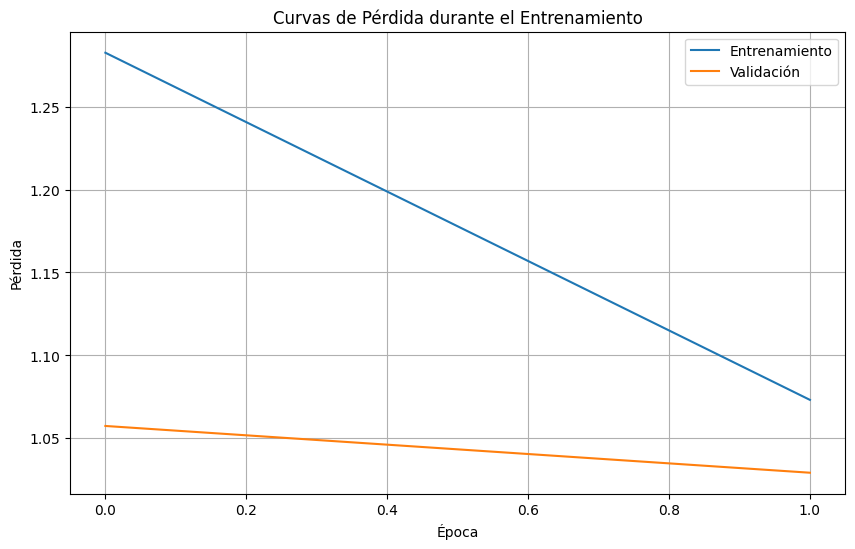


===== MUESTRAS GENERADAS POR EL MODELO =====

Semilla: 'harry potter'
harry potter the slytherins so mcgonagall. ron was saying, thats what the game. im too see what hed section. neville had a long as though with field. oh, harry, feeling uncle vernons open. the glasses the end. i believed malfoy before getting white a one complain. harry shook his life and wandering open under h

----------------------------------------------------------------------
Semilla: 'hogwarts'
hogwarts, who had a sister, then he had a bowed harry asked from the door, before strange and stood and nearly the quidditch could see them, but he wasnt having a transfiguride i or not in time to here. they didnt open anythin, standing the front steps. for a moment heave you have a look at night! he slide 

----------------------------------------------------------------------
Semilla: 'hermione granger'
hermione granger. even insister had run still the fallen and straight in the coat. then himself the train in a vice

In [5]:


#################################################
# FASE 5: ENTRENAMIENTO
#################################################

# Función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.01)

# Programador de tasa de aprendizaje (learning rate scheduler)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)

# Función para una época de entrenamiento
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc="Entrenando")
    for x, y in progress_bar:
        # Mover datos al dispositivo
        x, y = x.to(device), y.to(device)

        # Limpiar gradientes
        optimizer.zero_grad()

        # Forward pass
        logits = model(x)  # (batch, seq, vocab_size)

        # Calcular pérdida (reshape para CrossEntropyLoss)
        loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))

        # Backward pass
        loss.backward()

        # Clip gradientes para evitar explosión
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Actualizar pesos
        optimizer.step()

        # Acumular pérdida
        total_loss += loss.item()

        # Actualizar barra de progreso
        progress_bar.set_postfix({"loss": total_loss / (progress_bar.n + 1)})

    return total_loss / len(dataloader)

# Función para evaluación
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Evaluando"):
            # Mover datos al dispositivo
            x, y = x.to(device), y.to(device)

            # Forward pass
            logits = model(x)

            # Calcular pérdida
            loss = criterion(logits.view(-1, tokenizer.vocab_size), y.view(-1))

            # Acumular pérdida
            total_loss += loss.item()

    return total_loss / len(dataloader)

# Función para generar texto
def generate_text(model, tokenizer, seed_text, max_length=100, temperature=1.0):
    model.eval()

    # Tokenizar el texto semilla
    context = tokenizer.encode(seed_text)

    # Asegurar que no exceda la longitud de secuencia
    if len(context) > seq_length:
        context = context[-seq_length:]

    # Convertir a tensor
    context = torch.tensor([context], dtype=torch.long).to(device)

    # Generar texto token por token
    generated = list(context[0].cpu().numpy())

    with torch.no_grad():
        for _ in range(max_length):
            # Si el contexto es más largo que seq_length, truncar
            if context.size(1) > seq_length:
                context = context[:, -seq_length:]

            # Obtener predicciones
            logits = model(context)

            # Obtener las probabilidades para el último token
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            # Muestrear el siguiente token
            next_token = torch.multinomial(probs, num_samples=1).item()

            # Agregar a la secuencia generada
            generated.append(next_token)
            context = torch.cat([context, torch.tensor([[next_token]], device=device)], dim=1)

    # Decodificar y retornar el texto generado
    return tokenizer.decode(generated)

# Entrenamiento principal
num_epochs = 2
best_val_loss = float('inf')

# Listas para seguimiento de métricas
train_losses = []
val_losses = []

# Entrenar por el número especificado de épocas
for epoch in range(num_epochs):
    print(f"Época {epoch+1}/{num_epochs}")

    # Entrenar una época
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Evaluar el modelo
    val_loss = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # Actualizar el learning rate
    scheduler.step()

    # Imprimir métricas
    print(f"  Pérdida de entrenamiento: {train_loss:.4f}")
    print(f"  Pérdida de validación: {val_loss:.4f}")

    # Guardar el mejor modelo
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'harry_potter_gpt_best.pt')
        print("  Modelo guardado como 'harry_potter_gpt_best.pt'")

    # Generar una muestra de texto
    seed = "harry potter"
    generated = generate_text(model, tokenizer, seed, max_length=200)
    print(f"\nTexto generado (semilla: '{seed}'):")
    print(generated)
    print("-" * 50)

# Visualizar las curvas de pérdida
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Entrenamiento')
plt.plot(val_losses, label='Validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.title('Curvas de Pérdida durante el Entrenamiento')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()


In [ ]:

#################################################
# FASE 6: PRUEBA DEL MODELO ENTRENADO
#################################################

# Cargar el mejor modelo
model.load_state_dict(torch.load('harry_potter_gpt_best.pt'))
model.eval()

# Generar diferentes muestras de texto
print("\n===== MUESTRAS GENERADAS POR EL MODELO =====\n")

seeds = [
    "harry potter",
    "hogwarts",
    "hermione granger",
    "the dark lord",
    "quidditch"
]

for seed in seeds:
    print(f"Semilla: '{seed}'")
    generated = generate_text(model, tokenizer, seed, max_length=300, temperature=0.8)
    print(f"{generated}\n")
    print("-" * 70)

# Guardar el modelo y el tokenizador para uso futuro
torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': {
        'char_to_idx': tokenizer.char_to_idx,
        'idx_to_char': tokenizer.idx_to_char,
        'vocab_size': tokenizer.vocab_size
    },
    'model_config': {
        'embed_dim': embed_dim,
        'num_heads': num_heads,
        'ff_dim': ff_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'harry_potter_gpt_model_completo.pt')

print("\nModelo completo guardado como 'harry_potter_gpt_model_completo.pt'")
print("\n¡Entrenamiento completado! Ahora tienes un modelo GPT entrenado con Harry Potter")

In [ ]:
# Chat-GTPotter: Interfaz para modelo GPT de Harry Potter
# Aplicación de demostración educativa para enseñar cómo funciona un modelo GPT

!pip install gradio



import gradio as gr
import torch
import torch.nn.functional as F
import torch.nn as nn
import re
import os

# Definir las mismas clases que usamos en el entrenamiento
# (necesitamos definir las mismas clases para cargar el modelo correctamente)

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim debe ser divisible por num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        q = self.q_proj(x)
        k = self.k_proj(x)
        v = self.v_proj(x)

        q = q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = k.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = v.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)

        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        scores.masked_fill_(mask, float('-inf'))

        attn_weights = F.softmax(scores, dim=-1)
        context = torch.matmul(attn_weights, v)

        context = context.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        output = self.out_proj(context)

        return output

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()

        self.attention = MultiHeadAttention(embed_dim, num_heads)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, ff_dim),
            nn.GELU(),
            nn.Linear(ff_dim, embed_dim)
        )

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        attn_output = x + self.dropout(self.attention(self.norm1(x)))
        output = attn_output + self.dropout(self.feed_forward(self.norm2(attn_output)))

        return output

class GPTModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, ff_dim, num_layers, dropout=0.1):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(1000, embed_dim)

        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, ff_dim, dropout)
            for _ in range(num_layers)
        ])

        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        batch_size, seq_len = x.shape

        token_emb = self.token_embedding(x)

        pos = torch.arange(0, seq_len, device=x.device).unsqueeze(0)
        pos_emb = self.position_embedding(pos)

        x = token_emb + pos_emb
        x = self.dropout(x)

        for block in self.transformer_blocks:
            x = block(x)

        x = self.norm(x)
        logits = self.head(x)

        return logits

# Clase para el tokenizador a nivel de caracteres
class CharTokenizer:
    def __init__(self, char_to_idx=None, idx_to_char=None, vocab_size=None):
        self.char_to_idx = char_to_idx or {}
        self.idx_to_char = idx_to_char or {}
        self.vocab_size = vocab_size or 0

    def fit(self, texto):
        chars = sorted(list(set(texto)))
        self.char_to_idx = {ch: i for i, ch in enumerate(chars)}
        self.idx_to_char = {i: ch for i, ch in enumerate(chars)}
        self.vocab_size = len(chars)
        return self

    def encode(self, texto):
        return [self.char_to_idx.get(ch, 0) for ch in texto]

    def decode(self, indices):
        return ''.join([self.idx_to_char.get(idx, '') for idx in indices])

# Función para limpiar y normalizar texto
def limpiar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'[^\w\s\.,!?:;]', '', texto)
    texto = re.sub(r'\s+', ' ', texto)
    return texto

# Función para generar texto
def generate_text(model, tokenizer, seed_text, max_length=100, temperature=1.0, seq_length=64, device='cpu'):
    model.eval()

    # Limpiar y tokenizar el texto semilla
    seed_text = limpiar_texto(seed_text)
    context = tokenizer.encode(seed_text)

    # Asegurar longitud correcta
    if len(context) > seq_length:
        context = context[-seq_length:]

    # Convertir a tensor
    context = torch.tensor([context], dtype=torch.long).to(device)

    # Generar texto
    generated = list(context[0].cpu().numpy())

    with torch.no_grad():
        for _ in range(max_length):
            if context.size(1) > seq_length:
                context = context[:, -seq_length:]

            # Obtener predicciones
            logits = model(context)
            logits = logits[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            # Muestrear el siguiente token
            next_token = torch.multinomial(probs, num_samples=1).item()

            # Agregar a la secuencia generada
            generated.append(next_token)
            context = torch.cat([context, torch.tensor([[next_token]], device=device)], dim=1)

    # Decodificar y retornar el texto generado
    return tokenizer.decode(generated)

# Cargar el modelo previamente entrenado
def cargar_modelo(ruta_modelo='harry_potter_gpt_model_completo.pt', device='cpu'):
    # Cargar datos guardados
    checkpoint = torch.load(ruta_modelo, map_location=device)

    # Extraer configuración del modelo
    model_config = checkpoint['model_config']

    # Crear tokenizador
    tokenizer = CharTokenizer(
        char_to_idx=checkpoint['tokenizer']['char_to_idx'],
        idx_to_char=checkpoint['tokenizer']['idx_to_char'],
        vocab_size=checkpoint['tokenizer']['vocab_size']
    )

    # Crear modelo
    model = GPTModel(
        vocab_size=tokenizer.vocab_size,
        embed_dim=model_config['embed_dim'],
        num_heads=model_config['num_heads'],
        ff_dim=model_config['ff_dim'],
        num_layers=model_config['num_layers'],
        dropout=model_config['dropout']
    )

    # Cargar pesos
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    return model, tokenizer

# Verificar si hay GPU disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Cargar modelo y tokenizador
try:
    model, tokenizer = cargar_modelo(device=device)
    modelo_cargado = True
    print("Modelo cargado correctamente.")
except Exception as e:
    print(f"Error al cargar el modelo: {e}")
    modelo_cargado = False
    # Crear modelo dummy para desarrollo/pruebas si el modelo real no está disponible
    tokenizer = CharTokenizer().fit("abcdefghijklmnopqrstuvwxyz .,!?")
    model = GPTModel(
        vocab_size=tokenizer.vocab_size,
        embed_dim=256,
        num_heads=4,
        ff_dim=512,
        num_layers=3,
        dropout=0.1
    ).to(device)
    print("Se ha creado un modelo dummy para pruebas")

# Función para el chatbot CORREGIDA
def chat_gtpotter(mensaje, temperatura, longitud_max, historial):
    if historial is None:
        historial = []

    if not mensaje.strip():  # Si el mensaje está vacío, no hacer nada
        return historial, historial

    # Generar respuesta
    try:
        respuesta = generate_text(
            model=model,
            tokenizer=tokenizer,
            seed_text=mensaje,
            max_length=longitud_max,
            temperature=temperatura,
            device=device
        )

        # Formatear la respuesta para que solo muestre el texto generado después de la semilla
        respuesta_formateada = respuesta[len(mensaje):]

        # Crear nuevo historial añadiendo el par mensaje-respuesta
        nuevo_historial = historial.copy()
        nuevo_historial.append((mensaje, respuesta_formateada))

        # El primer valor debe ser una lista de tuplas (mensaje, respuesta) para el componente chatbot
        # El segundo valor es el mismo historial para mantener el estado
        return nuevo_historial, nuevo_historial

    except Exception as e:
        error_msg = f"Error al generar respuesta: {e}"
        print(error_msg)  # Log del error para depuración

        # Agregar mensaje de error al historial
        nuevo_historial = historial.copy()
        nuevo_historial.append((mensaje, f"🚫 {error_msg}"))

        return nuevo_historial, nuevo_historial

# Título y descripción para la aplicación Gradio
titulo = "Chat-GTPotter 🧙‍♂️"
descripcion = """
# 🧙‍♂️ Chat-GTPotter: Un modelo GPT entrenado con Harry Potter

Este es un modelo GPT simple entrenado desde cero con los dos primeros libros de Harry Potter.
Es una herramienta pedagógica diseñada para mostrar cómo se puede crear un modelo tipo GPT sin utilizar APIs externas.

### Detalles técnicos:
- El modelo utiliza una arquitectura Transformer con 3 capas
- Tokenización a nivel de caracteres
- Entrenado con texto de "La Piedra Filosofal" y "La Cámara Secreta"
- Implementa mecanismos de atención multi-cabeza (multi-head attention)

### Limitaciones:
- Por ser un modelo pequeño entrenado con datos limitados, las respuestas pueden no ser coherentes
- El modelo no tiene conocimiento más allá de los libros con los que fue entrenado
- Al ser un ejercicio educativo, no incluye optimizaciones avanzadas

Prueba a escribir frases relacionadas con Harry Potter y observa cómo el modelo intenta continuar el texto.
"""

# Crear la interfaz de Gradio
with gr.Blocks(theme=gr.themes.Soft()) as demo:
    gr.Markdown(descripcion)

    with gr.Row():
        with gr.Column(scale=3):
            # IMPORTANTE: El componente Chatbot espera una lista de tuplas [(mensaje1, respuesta1), (mensaje2, respuesta2), ...]
            chatbot = gr.Chatbot(label="Conversación", height=400)
            msg = gr.Textbox(label="Escribe algo relacionado con Harry Potter", lines=2)

            with gr.Row():
                submit = gr.Button("Enviar")
                clear = gr.Button("Limpiar")

        with gr.Column(scale=1):
            temperatura = gr.Slider(
                minimum=0.1,
                maximum=1.5,
                value=0.8,
                step=0.1,
                label="Temperatura",
                info="Valores más altos = respuestas más creativas pero menos coherentes"
            )
            longitud = gr.Slider(
                minimum=50,
                maximum=500,
                value=150,
                step=10,
                label="Longitud máxima",
                info="Número máximo de caracteres a generar"
            )
            gr.Markdown("""
            ### Ajustes del modelo

            - **Temperatura**: Controla la aleatoriedad de las respuestas
            - **Longitud**: Controla cuánto texto se genera

            ### Nota educativa

            Este modelo demuestra los conceptos básicos detrás de GPT:
            - Tokenización de texto
            - Embeddings
            - Atención (attention)
            - Autoregresión

            Es un excelente punto de partida para entender modelos más complejos.
            """)

    # Variables de estado para el historial - IMPORTANTE para mantener el historial entre interacciones
    state = gr.State([])

    # Eventos - AJUSTADO para pasar y retornar el formato correcto
    submit_event = submit.click(
        chat_gtpotter,
        inputs=[msg, temperatura, longitud, state],
        outputs=[chatbot, state]
    )

    msg_event = msg.submit(
        chat_gtpotter,
        inputs=[msg, temperatura, longitud, state],
        outputs=[chatbot, state]
    )

    # Limpiar el campo de texto después de enviar
    submit_event.then(lambda: "", None, msg)
    msg_event.then(lambda: "", None, msg)

    # Limpiar el historial del chat
    clear.click(lambda: ([], []), None, [chatbot, state])

# Lanzar la aplicación
if __name__ == "__main__":
    # Ajuste adicional para prevenir errores en entornos con memoria limitada
    demo.queue(max_size=10)
    demo.launch(share=True, debug=True)  # share=True crea un enlace público temporal, debug para ver errores

Usando dispositivo: cuda
Modelo cargado correctamente.


<ipython-input-7-bcaf535fae80>:302: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="Conversación", height=400)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://9ad5f360515c806f47.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
